<a href="https://colab.research.google.com/github/ram130849/spatio_temporal_modelling/blob/main/Spatio_Temporal_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 52.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-gqc8_1w3
  Running command git clone --filter=blob:none --quiet https://github.com/py

In [2]:
!pip install torch-geometric-temporal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 48.0 MB/s eta 0:00:00
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86726 sha256=c98249d0962d214e69533a72d20b89eb72dcdfacb0663e3503f7fbb1811f28e9
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c
Successfully built torch-geometric-temporal
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas

In [3]:
from torch_geometric_temporal.dataset import PemsBayDatasetLoader,ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.nn.recurrent import DCRNN
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

In [30]:
loader = PemsBayDatasetLoader()
dataset = loader.get_dataset()
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(list(dataset)))
print(next(iter(dataset)))
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f5a8f36d180>
Number of samples / sequences:  52082
Data(x=[325, 2, 12], edge_index=[2, 2694], edge_attr=[2694], y=[325, 2, 12])


In [6]:
# Get the length of the train dataset.
print(len(list(train_dataset)))

10416


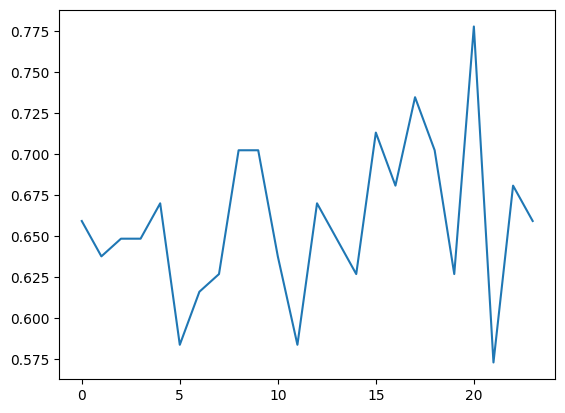

In [7]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0][1].item() for bucket in list(dataset)[:hours]]

plt.plot(sensor_labels)

In [41]:
print(train_dataset.edge_index.shape)

(2, 2694)


In [32]:
# Train Dataset Loader
train_input = np.array(train_dataset.features) 
train_target = np.array([target[:,1,:] for target in train_dataset.targets]) 
train_edge_idx = np.array(train_dataset.edge_index)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE) 
train_edge_idx_tensor = torch.from_numpy(train_edge_idx).type(torch.int64).to(DEVICE)

train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

test_input = np.array(test_dataset.features) 
test_target = np.array([target[:,1,:] for target in test_dataset.targets]) 
test_edge_idx = np.array(test_dataset.edge_index)
test_edge_idx_tensor = torch.from_numpy(test_edge_idx).type(torch.int64).to(DEVICE)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)

test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [7]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [8]:
model = RecurrentGCN(node_features = 2)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

RecurrentGCN(
  (recurrent): DCRNN(
    (conv_x_z): DConv(34, 32)
    (conv_x_r): DConv(34, 32)
    (conv_x_h): DConv(34, 32)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
for epoch in tqdm(range(5)):
    cost = 0
    count = 0
    for time, snapshot in enumerate(train_dataset):
        snapshot = snapshot.to(DEVICE)
        cost1 = 0
        torch.cuda.empty_cache()
        for i in range(12):
            y_hat = model(snapshot.x[:,:,i], snapshot.edge_index, snapshot.edge_attr)
            cost1 = cost1 + torch.mean((y_hat-snapshot.y[:,:,i])**2)
        cost += cost1
    print('time:',time)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/5 [02:33<?, ?it/s]


OutOfMemoryError: ignored

In [18]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

In [19]:
model = TemporalGNN(node_features=2, periods=12, batch_size=2)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.MSELoss()

model.train()

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [ ]:
train_dataset.features

In [38]:
for time,snapshot in enumerate(train_dataset):
    print(snapshot.edge_index)
    static_edge_index = snapshot.edge_index
    break;

tensor([[  0,   1,   2,  ..., 324, 324, 324],
        [  0,   1,   2,  ..., 257, 310, 324]])


In [39]:
model.train()

for epoch in range(10):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs.to(DEVICE), static_edge_index.to(DEVICE))         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0:
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.384915015809238
0.3106895900052041
0.2875036360012988
Epoch 0 train RMSE: 0.2817
0.24873976539820433
0.23412544754333794
0.21928786337996523
Epoch 1 train RMSE: 0.2173
0.22452540699392556
0.2071872833929956
0.20712883930653334
Epoch 2 train RMSE: 0.2069
0.20129216952249407
0.2035222185961902
0.20329596624399224
Epoch 3 train RMSE: 0.2004
0.19790160208940505
0.204185942215845
0.19985382466266552
Epoch 4 train RMSE: 0.1967
0.1846940267086029
0.19106200584210456
0.19385560182233652
Epoch 5 train RMSE: 0.1936
0.21039750304073096
0.19390617260709406
0.19507542475437126
Epoch 6 train RMSE: 0.1930
0.2009664631448686
0.20525844854302705
0.1923183212429285
Epoch 7 train RMSE: 0.1924
0.17930897504091262
0.1905417062714696
0.19373116574560603
Epoch 8 train RMSE: 0.1917
0.19233854178339244
0.18922358733601868
0.19294247101371487
Epoch 9 train RMSE: 0.1901


In [40]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs.to(DEVICE), static_edge_index.to(DEVICE))
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.1921


In [41]:
sensor = 112
timestep = 10 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

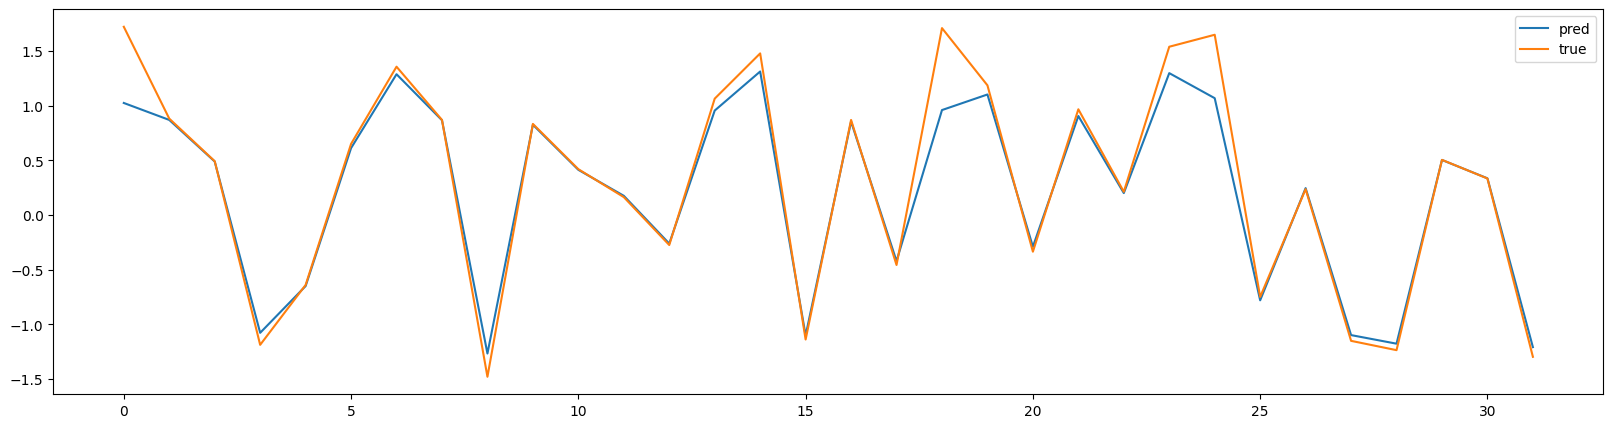

In [42]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

In [8]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.8 MB/s eta 0:00:00


In [10]:
from torch_geometric_temporal.nn.attention import ASTGCN
import torch.nn as nn
from tensorboardX import SummaryWriter
from time import time

In [11]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
num_of_hours = 1
num_of_vertices = 325
time_strides = num_of_hours
num_for_predict = 12
len_input = 12

sw = SummaryWriter(logdir='.', flush_secs=5)

net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

print(net)

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), strid

In [12]:
learning_rate = 0.001
start_time= time()
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)

total_param = 0
for param_tensor in net.state_dict():
    total_param += np.prod(net.state_dict()[param_tensor].size())

for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.01, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]}]


In [13]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [14]:
masked_flag=0
criterion = nn.L1Loss().to(DEVICE)
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0
global_step = 0
best_epoch = 0

if loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

In [15]:
for epoch in tqdm(range(10)):
    net.train()  # ensure dropout layers are in train mode
    for encoder_inputs,labels in train_loader:
        optimizer.zero_grad()
        for i in range(2):
            outputs = net(encoder_inputs[:,:,i,:].view(encoder_inputs.shape[0],encoder_inputs.shape[1],1,encoder_inputs.shape[3]), train_edge_idx_tensor) 
            if masked_flag:
                loss = criterion_masked(outputs, labels,missing_value)
            else:
                loss = criterion(outputs, labels)
            
    loss.backward()
    optimizer.step()
    training_loss = loss.item()
    global_step += 1
    sw.add_scalar('training_loss', training_loss, global_step)

    if global_step % 200 == 0:
        print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))

100%|██████████| 10/10 [07:27<00:00, 44.74s/it]


In [17]:
net.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = net(encoder_inputs[:,:,i,:].view(encoder_inputs.shape[0],encoder_inputs.shape[1],1,encoder_inputs.shape[3]), train_edge_idx_tensor)
        loss = criterion(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 100 == 0:
            print('test_loss batch %s / %s, loss: %.2f' % (batch_index + 1, test_loader_length, loss.item()))

    test_loss = sum(tmp) / len(tmp)
    sw.add_scalar('test_loss', test_loss, epoch)
print('final Loss:',test_loss)

test_loss batch 1 / 1302, loss: 0.85
test_loss batch 101 / 1302, loss: 0.78
test_loss batch 201 / 1302, loss: 0.66
test_loss batch 301 / 1302, loss: 0.78
test_loss batch 401 / 1302, loss: 0.78
test_loss batch 501 / 1302, loss: 0.62
test_loss batch 601 / 1302, loss: 0.82
test_loss batch 701 / 1302, loss: 0.74
test_loss batch 801 / 1302, loss: 0.60
test_loss batch 901 / 1302, loss: 0.65
test_loss batch 1001 / 1302, loss: 0.89
test_loss batch 1101 / 1302, loss: 0.72
test_loss batch 1201 / 1302, loss: 0.80
test_loss batch 1301 / 1302, loss: 0.73
0.7609429941290901
